## Distorted maps

Dataset: Theoretical Train Travel Times


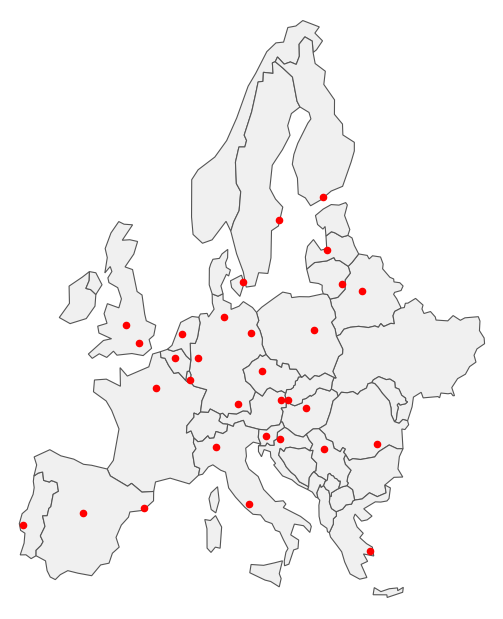

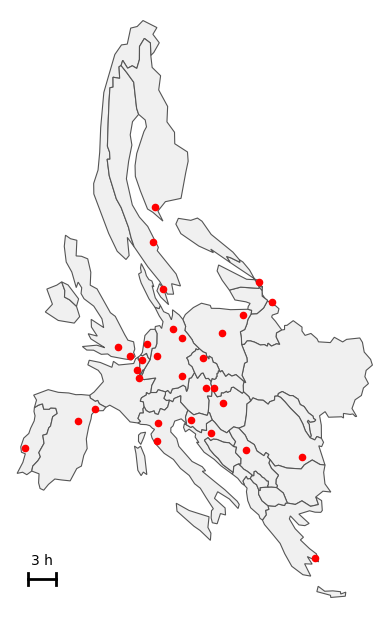

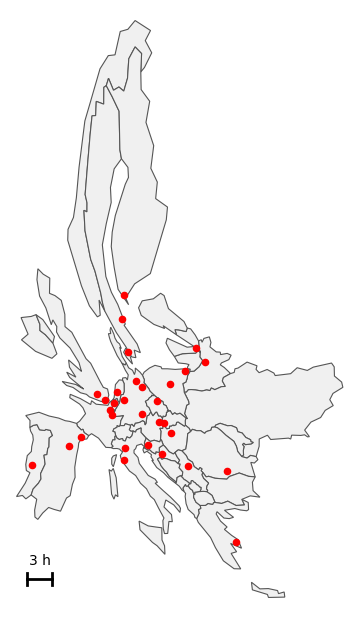

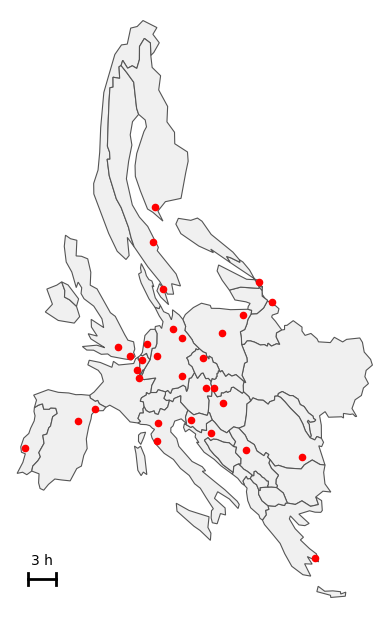

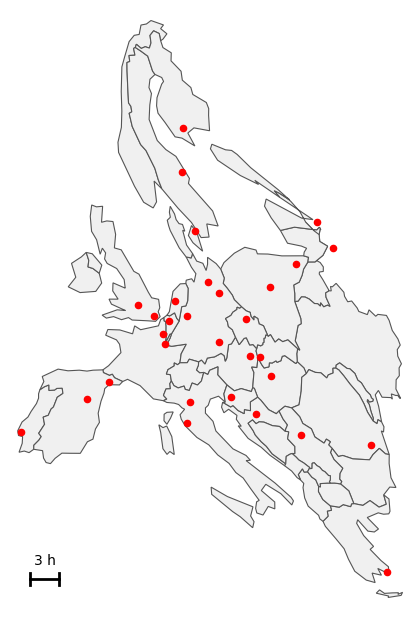

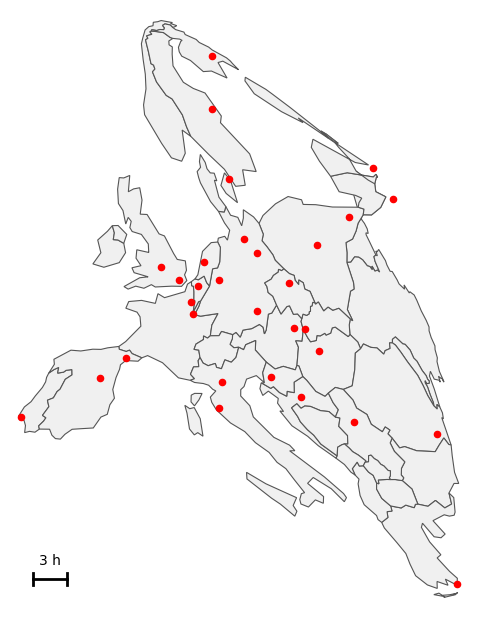

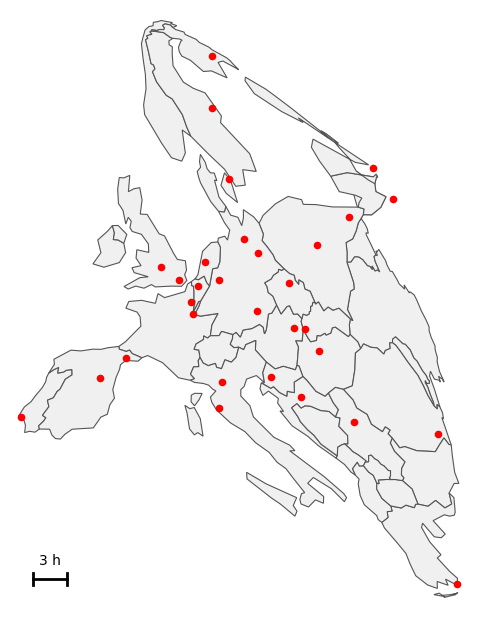

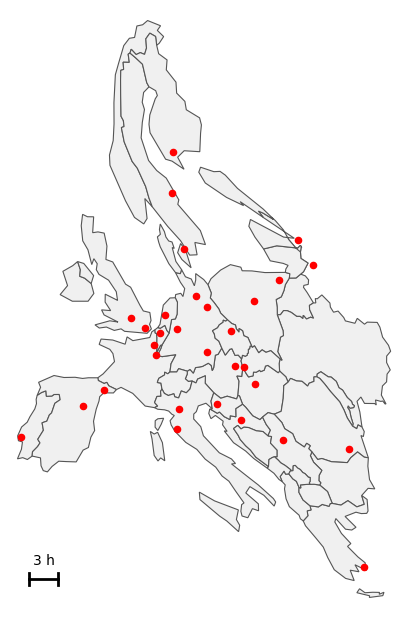

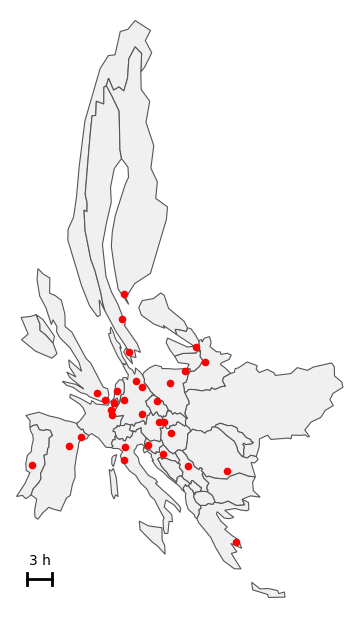

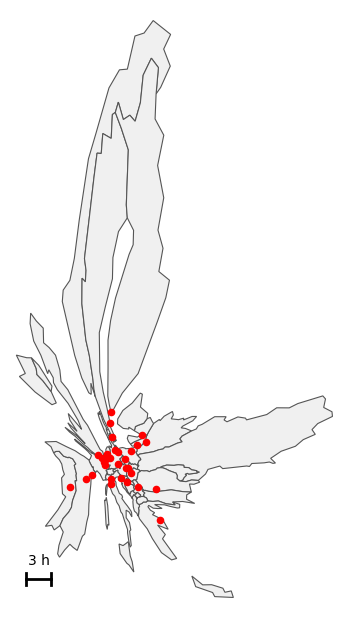

Dataset: Computed Train travel times


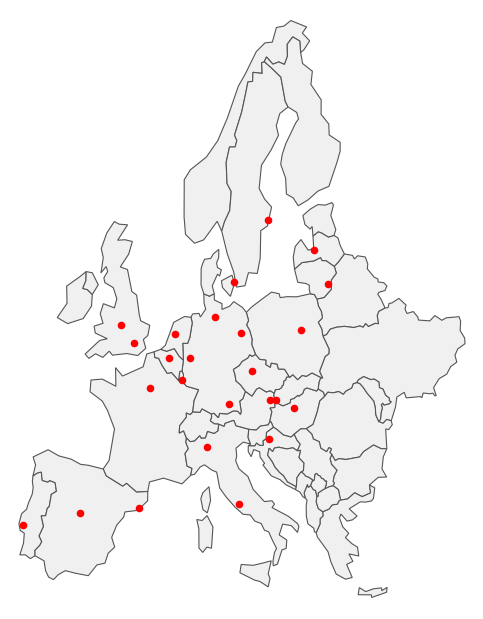

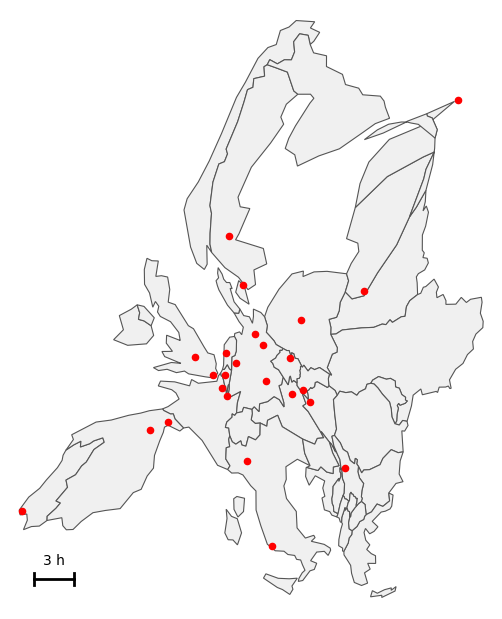

Dataset: Theoretical Car Travel Times


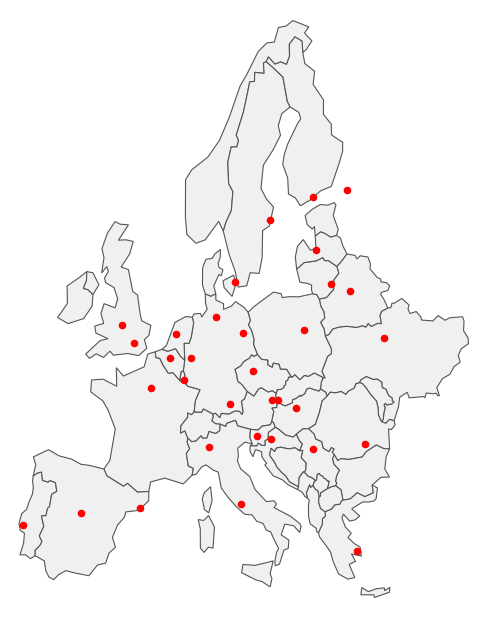

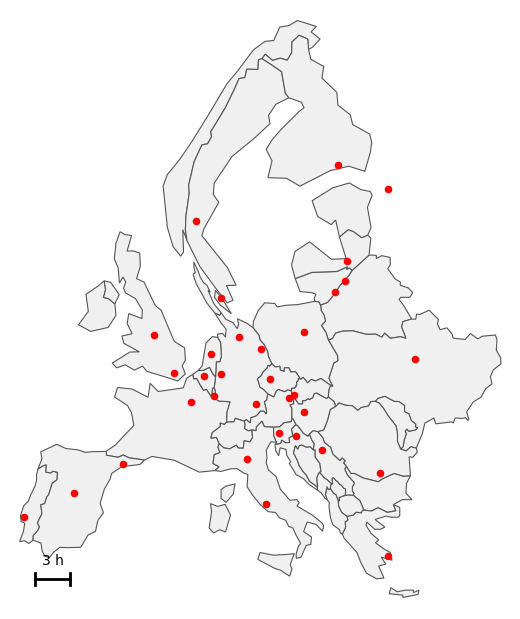

All maps exported to PDF.


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyproj
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

# --- Configuration ---
TIME_SCALE       = 0.01
SPRING_CONSTANT  = 1e-5
LEARNING_RATE    = 0.5
ITERATIONS       = 100_000
SMOOTHING_EPS    = 1.0      # RBF smoothing ε
SCALE_FACTOR     = 10**(-3.3)

CONFIG_PATH      = '/var/www/distorted_maps/config/config.json'
GEOJSON_BASE_DIR = '/var/www/distorted_maps/'

# --- Coordinate transformer (WGS84→EPSG:3035) ---
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)

# --- Helper Functions ---
def to_plot_coords(x, y, xlim, ylim):
    return (x - xlim[0])/(xlim[1]-xlim[0]), (y - ylim[0])/(ylim[1]-ylim[0])

def setup_plot(ax):
    ax.axis('off')
    ax.set_aspect('equal')
    ax.margins(0.02)

def draw_geojson(ax, geojson, stations=None, xlim=None, ylim=None):
    for feature in geojson['features']:
        geom = feature['geometry']
        if geom['type'] in ('Polygon','MultiPolygon'):
            polys = geom['coordinates'] if geom['type']=='Polygon' else sum(geom['coordinates'], [])
            for ring in polys:
                pts = np.array(ring)
                xs, ys = to_plot_coords(pts[:,0], pts[:,1], xlim, ylim)
                poly = Polygon(
                    np.column_stack([xs,ys]),
                    facecolor='#f0f0f0', edgecolor='#555555', linewidth=0.8
                )
                ax.add_patch(poly)
    if stations:
        pts = [to_plot_coords(p['x'], p['y'], xlim, ylim) for p in stations]
        xs, ys = zip(*pts)
        ax.scatter(xs, ys, s=20, zorder=5, color='red')

def draw_scale_bar(ax, xlim, ylim, hour_scale=1):
    """Draw a horizontal scale bar of length = hour_scale hours."""
    # length in data units: L = hours * seconds/hour * TIME_SCALE  / SCALE_FACTOR
    L = hour_scale * 3600 * TIME_SCALE / SCALE_FACTOR
    # normalized length in [0,1]
    length_norm = L / (xlim[1] - xlim[0])
    x0, y0 = 0.05, 0.05
    ax.plot(
        [x0, x0 + length_norm], [y0, y0],
        transform=ax.transAxes,
        linewidth=2,
        color='black'
    )
    ax.text(
        x0 + length_norm/2, y0 + 0.02,
        f"{hour_scale} h",
        transform=ax.transAxes,
        ha='center', va='bottom',
        fontsize=10
    )
    # Add two small vertical lines at the ends
    ax.plot(
        [x0, x0], [y0 - 0.01, y0 + 0.01],
        transform=ax.transAxes,
        linewidth=2,
        color='black'
    )
    ax.plot(
        [x0 + length_norm, x0 + length_norm], [y0 - 0.01, y0 + 0.01],
        transform=ax.transAxes,
        linewidth=2,
        color='black'
    )

def run_simulation(original_proj, travel_times,
                   time_scale=TIME_SCALE,
                   spring_const=SPRING_CONSTANT,
                   lr=LEARNING_RATE,
                   total_iters=ITERATIONS,
                   s_factor=SCALE_FACTOR,
                   smoothing_eps=SMOOTHING_EPS):
    coords = np.array([[p['x'], p['y']] for p in original_proj])
    center = coords.mean(axis=0)
    pos = (coords - center) * s_factor
    n = len(coords)

    desired = np.zeros((n,n))
    for key, t in travel_times.items():
        i,j = map(int, key.split('-'))
        desired[i,j] = desired[j,i] = t * time_scale

    for _ in tqdm(range(total_iters), desc="Simulating", leave=False):
        diffs = pos[:,None,:] - pos[None,:,:]
        dists = np.linalg.norm(diffs, axis=2) + 1e-9
        forces = -spring_const * (dists - desired)[...,None] * (diffs / dists[...,None])
        pos += lr * forces.sum(axis=1)

    disp = (pos / s_factor + center) - coords

    eps = smoothing_eps
    dmat = squareform(pdist(coords))
    A = np.sqrt(dmat**2 + eps**2)
    w_x = np.linalg.solve(A, disp[:,0])
    w_y = np.linalg.solve(A, disp[:,1])

    def rbf_dx(x, y):
        r = np.sqrt((x - coords[:,0])**2 + (y - coords[:,1])**2 + eps**2)
        return np.dot(w_x, r)

    def rbf_dy(x, y):
        r = np.sqrt((x - coords[:,0])**2 + (y - coords[:,1])**2 + eps**2)
        return np.dot(w_y, r)

    return rbf_dx, rbf_dy

def distort_geojson(geojson, original_proj, rbf_dx, rbf_dy):
    def recurse(coords):
        if isinstance(coords[0], (int, float)):
            x,y = coords
            return [x + rbf_dx(x,y), y + rbf_dy(x,y)]
        else:
            return [recurse(c) for c in coords]

    warped = json.loads(json.dumps(geojson))
    for feat in tqdm(warped['features'], desc="Warping map", leave=False):
        feat['geometry']['coordinates'] = recurse(feat['geometry']['coordinates'])

    warped['_stations'] = []
    for p in original_proj:
        warped['_stations'].append({
            'x': p['x'] + rbf_dx(p['x'], p['y']),
            'y': p['y'] + rbf_dy(p['x'], p['y'])
        })
    return warped

def export_map(geojson, stations, xlim, ylim, fname, add_scale=False, plot=True):
    fig, ax = plt.subplots(figsize=(6,6))
    setup_plot(ax)
    draw_geojson(ax, geojson, stations=stations, xlim=xlim, ylim=ylim)
    if add_scale:
        draw_scale_bar(ax, xlim, ylim, hour_scale=3)
    fig.tight_layout(pad=0)
    fig.savefig(fname, dpi=300, bbox_inches='tight')
    if plot:
        plt.show()
    plt.close(fig)

# === Main Script ===

with open(CONFIG_PATH) as f:
    config = json.load(f)

for ds_key in config['datasets']:
    ds = config['datasets'][ds_key]
    print(f"Dataset: {ds['name']}")

    # Load GeoJSON
    with open(GEOJSON_BASE_DIR + ds['geojsonUrl']) as f:
        geojson_data = json.load(f)

    # Project stations
    original_proj = []
    for loc in ds['locations']:
        x,y = transformer.transform(loc['lon'], loc['lat'])
        original_proj.append({'x': x, 'y': y})

    # Compute bounding box
    xs = [p['x'] for p in original_proj]
    ys = [p['y'] for p in original_proj]
    xlim, ylim = [min(xs), max(xs)], [min(ys), max(ys)]

    # 1) Original map (no scale bar)
    export_map(
        geojson=geojson_data,
        stations=original_proj,
        xlim=xlim, ylim=ylim,
        fname=f"original_map_{ds_key}.pdf",
        add_scale=False
    )

    # 2) Time‑distorted cartogram (with scale bar)
    rbf_dx, rbf_dy = run_simulation(
        original_proj, ds['travelTimes'],
        time_scale=TIME_SCALE,
        spring_const=SPRING_CONSTANT,
        lr=LEARNING_RATE,
        total_iters=ITERATIONS,
        s_factor=SCALE_FACTOR,
        smoothing_eps=SMOOTHING_EPS
    )
    warped = distort_geojson(geojson_data, original_proj, rbf_dx, rbf_dy)
    export_map(
        geojson=warped,
        stations=warped['_stations'],
        xlim=xlim, ylim=ylim,
        fname=f"distorted_map_{ds_key}.pdf",
        add_scale=True
    )

    # 3) α & s experiments for first dataset only
    if ds_key == list(config['datasets'].keys())[0]:
        # α experiments
        for α in [0.005, 0.01, 0.02, 0.05]:
            rbf_dx, rbf_dy = run_simulation(
                original_proj, ds['travelTimes'],
                time_scale=α,
                spring_const=SPRING_CONSTANT,
                lr=LEARNING_RATE,
                total_iters=ITERATIONS,
                s_factor=SCALE_FACTOR,
                smoothing_eps=SMOOTHING_EPS
            )
            warped_α = distort_geojson(geojson_data, original_proj, rbf_dx, rbf_dy)
            export_map(
                geojson=warped_α,
                stations=warped_α['_stations'],
                xlim=xlim, ylim=ylim,
                fname=f"distorted_map_alpha_{str(α).replace('.','_')}.pdf",
                add_scale=True
            )

        # s experiments
        for sf in [10**(-4), 10**(-3.5), 10**(-3), 10**(-2.5)]:
            rbf_dx, rbf_dy = run_simulation(
                original_proj, ds['travelTimes'],
                time_scale=TIME_SCALE,
                spring_const=SPRING_CONSTANT,
                lr=LEARNING_RATE,
                total_iters=ITERATIONS,
                s_factor=sf,
                smoothing_eps=SMOOTHING_EPS
            )
            warped_s = distort_geojson(geojson_data, original_proj, rbf_dx, rbf_dy)
            export_map(
                geojson=warped_s,
                stations=warped_s['_stations'],
                xlim=xlim, ylim=ylim,
                fname=f"distorted_map_scale_{round(np.log10(sf), 1)}.pdf",
                add_scale=True
            )

print("All maps exported to PDF.")

## Interactive Map

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from scipy.interpolate import Rbf
import pyproj
from ipywidgets import interact, FloatSlider, FloatLogSlider, IntSlider, Button, VBox, Output
from IPython.display import display, clear_output

# Pre-load the European base map (this only needs to be done once)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
europe = world[world['CONTINENT'] == 'Europe']
# Exclude Russia, Greenland, etc.
europe = europe[~europe['NAME'].isin(['Russia', 'Greenland'])]
# Define bounding box for plotting (EPSG:3035)
xlim = (2500000, 6000000)
ylim = (1400000, 5500000)
# Reproject to a metric CRS (ETRS89 / LAEA)
europe = europe.to_crs(epsg=3035)

# Output widget for displaying the plot
output = Output()

def run_simulation(time_scale=0.01, spring_constant=1e-6, learning_rate=0.1, 
                   num_iterations=50000, scale_factor=1e-5, smooth=0):
    with output:
        clear_output(wait=True)
        print("Loading...")
        # --- 1. Define Cities & Convert to Global Coordinates ---
        cities = {
            'Paris': (2.3522, 48.8566),
            'Brussels': (4.3517, 50.8503),
            'Berlin': (13.4050, 52.5200)
        }
        city_names = list(cities.keys())
        proj_transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3035", always_xy=True)
        orig_positions = []
        for city in city_names:
            lon, lat = cities[city]
            x, y = proj_transformer.transform(lon, lat)
            orig_positions.append([x, y])
        orig_positions = np.array(orig_positions)  # shape (n,2)
        # Save original positions as a dict for plotting
        original_global = {city_names[i]: orig_positions[i] for i in range(len(city_names))}
        
        # --- 2. Set Up Simulation (Center & Scale for Numerical Stability) ---
        center = np.mean(orig_positions, axis=0)
        positions = (orig_positions - center) * scale_factor  # simulation coordinates
        n = len(city_names)
        
        # Desired distances (simulation units) based on travel times: 5h, 6h, and 2h.
        travel_times = {
            ('Paris', 'Brussels'): 5*3600,
            ('Paris', 'Berlin'): 6*3600,
            ('Brussels', 'Berlin'): 2*3600
        }
        desired = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                t = travel_times.get((city_names[i], city_names[j]), 
                                     travel_times.get((city_names[j], city_names[i]), 0))
                d = t * time_scale
                desired[i, j] = d
                desired[j, i] = d
        
        # Prepare the base map geometry (we work on a copy so we can reapply distortion)
        base_geoms = europe['geometry'].copy()
        
        # Set up the figure with two subplots: left for original, right for evolving distorted map.
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        # Original Map (static)
        europe.plot(ax=axs[0], color='lightblue', edgecolor='black')
        for city in city_names:
            axs[0].plot(original_global[city][0], original_global[city][1], 'ro')
            axs[0].text(original_global[city][0], original_global[city][1], city, fontsize=10)
        axs[0].set_xlim(xlim)
        axs[0].set_ylim(ylim)
        axs[0].set_title("Original Map (Projected)")
        axs[0].axis('off')
        
        # Create a placeholder for the distorted map.
        axs[1].set_xlim(xlim)
        axs[1].set_ylim(ylim)
        axs[1].set_title("Distorted Time Map")
        axs[1].axis('off')
        distorted_plot = None
        
        # Define the distortion function using RBF given global control points.
        def update_distortion(displacements):
            # Control points: original global positions.
            city_x = np.array([original_global[city][0] for city in city_names])
            city_y = np.array([original_global[city][1] for city in city_names])
            disp_x = np.array([displacements[city][0] for city in city_names])
            disp_y = np.array([displacements[city][1] for city in city_names])
            rbf_disp_x = Rbf(city_x, city_y, disp_x, function='multiquadric', smooth=smooth)
            rbf_disp_y = Rbf(city_x, city_y, disp_y, function='multiquadric', smooth=smooth)
            def distort_geometry(geom):
                if geom.is_empty:
                    return geom
                if geom.geom_type == 'Point':
                    x, y = geom.coords[0]
                    return Point(x + rbf_disp_x(x, y), y + rbf_disp_y(x, y))
                elif geom.geom_type in ['LineString', 'LinearRing']:
                    new_coords = [(x + rbf_disp_x(x, y), y + rbf_disp_y(x, y)) for x, y in geom.coords]
                    return type(geom)(new_coords)
                elif geom.geom_type == 'Polygon':
                    new_exterior = distort_geometry(geom.exterior)
                    new_interiors = [distort_geometry(ring) for ring in geom.interiors]
                    return Polygon(new_exterior, new_interiors)
                elif geom.geom_type.startswith('Multi') or geom.geom_type == 'GeometryCollection':
                    return type(geom)([distort_geometry(part) for part in geom.geoms])
                else:
                    return geom
            return base_geoms.apply(distort_geometry)
        
        # Determine batch size for animation updates.
        batch_size = max(1, num_iterations // 100)
        
        # --- 3. Animation Loop: Run Simulation & Update Plot ---
        for it in range(0, num_iterations, batch_size):
            # Run batch_size simulation steps
            for _ in range(batch_size):
                diff = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]  # shape (n,n,2)
                distances = np.linalg.norm(diff, axis=2) + 1e-9  # avoid division by zero
                force_mags = spring_constant * (distances - desired)
                force_vectors = (force_mags[..., np.newaxis] * diff) / distances[..., np.newaxis]
                net_forces = np.sum(force_vectors, axis=1)
                positions += learning_rate * net_forces
            
            # Update simulated positions in global coordinates.
            new_positions = (positions / scale_factor) + center
            # Compute displacements for control points.
            displacements = {city_names[i]: new_positions[i] - original_global[city_names[i]] 
                             for i in range(n)}
            
            # Update distorted geometries.
            distorted_geoms = update_distortion(displacements)
            
            # Clear and update the distorted map subplot.
            axs[1].clear()
            axs[1].set_xlim(xlim)
            axs[1].set_ylim(ylim)
            axs[1].set_title("Distorted Time Map")
            axs[1].axis('off')
            gpd.GeoSeries(distorted_geoms).plot(ax=axs[1], color='lightgreen', edgecolor='black')
            # Plot updated city positions on distorted map.
            for city in city_names:
                axs[1].plot(new_positions[city_names.index(city)][0], new_positions[city_names.index(city)][1], 'ro')
                axs[1].text(new_positions[city_names.index(city)][0], new_positions[city_names.index(city)][1], city, fontsize=10)
            fig.canvas.draw_idle()
            plt.pause(0.001)
        
        # Finished: Remove "Loading..." text.
        clear_output(wait=True)
        display(fig)


# Interactive widgets: each parameter gets a descriptive name and a sensible range.
time_scale_slider = FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001, description='Time Scale')
spring_constant_slider = FloatLogSlider(value=1e-6, base=10, min=-7, max=-4, step=0.1, description='Spring Constant')
learning_rate_slider = FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Learning Rate')
num_iterations_slider = IntSlider(value=50000, min=1000, max=100000, step=1000, description='Iterations')
scale_factor_slider = FloatLogSlider(value=1e-5, base=10, min=-7, max=-3, step=0.1, description='Scale Factor')
smooth_slider = FloatSlider(value=0, min=0, max=10, step=0.5, description='Smooth')

def reset_values(button):
    time_scale_slider.value = 0.01
    spring_constant_slider.value = 1e-6
    learning_rate_slider.value = 0.1
    num_iterations_slider.value = 50000
    scale_factor_slider.value = 1e-5
    smooth_slider.value = 0

reset_button = Button(description="Reset to Default")
reset_button.on_click(reset_values)

ui = VBox([time_scale_slider, spring_constant_slider, learning_rate_slider, num_iterations_slider, scale_factor_slider, smooth_slider, reset_button, output])
display(ui)

interact(run_simulation, 
         time_scale=time_scale_slider, 
         spring_constant=spring_constant_slider, 
         learning_rate=learning_rate_slider, 
         num_iterations=num_iterations_slider, 
         scale_factor=scale_factor_slider, 
         smooth=smooth_slider)


In [ ]:
data_motis, data_car, data_train = {}, {}, {}

for file in files:
    if file.endswith(".csv") and file.startswith("travel_times"):
        start_station_id, timestamp, travel_type = file[len("travel_times_"):-4].split("_")
        start_station_id = int(start_station_id)

        travel_times = pd.read_csv(os.path.join(folder, file), usecols=['station_id', 'travel_time'])
        travel_times = travel_times.dropna(subset=['travel_time'])
        travel_times = travel_times[travel_times['travel_time'] > 0]

        if travel_type == 'motis':
            data_dict = data_motis
        elif travel_type == 'car':
            data_dict = data_car
        elif travel_type == 'train':
            data_dict = data_train
        else:
            print(f"Unknown travel type: {travel_type}")
            continue  # Skip unknown travel type

        if start_station_id not in data_dict:
            data_dict[start_station_id] = {}

        for station_id, travel_time in travel_times.values:
            if station_id not in start_stations:
                continue
            station_id = int(station_id)  # Ensure station_id is an int
            if station_id not in data_dict:
                data_dict[station_id] = {}
            if start_station_id in data_dict[station_id]:
                data_dict[station_id][start_station_id] = min(data_dict[station_id][start_station_id], travel_time)
                data_dict[start_station_id][station_id] = data_dict[station_id][start_station_id]
            else:
                data_dict[start_station_id][station_id] = travel_time
                data_dict[station_id][start_station_id] = travel_time

# Convert dictionaries to DataFrames
travel_matrix_motis = pd.DataFrame.from_dict(data_motis, orient='index').fillna(0)
travel_matrix_car = pd.DataFrame.from_dict(data_car, orient='index').fillna(0)
travel_matrix_train = pd.DataFrame.from_dict(data_train, orient='index').fillna(0)

# Sort index and columns
travel_matrix_motis = travel_matrix_motis.sort_index(axis=0).sort_index(axis=1)
travel_matrix_car = travel_matrix_car.sort_index(axis=0).sort_index(axis=1)
travel_matrix_train = travel_matrix_train.sort_index(axis=0).sort_index(axis=1)

In [ ]:
# plot as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get station names for labels
station_names = stations_df.apply(lambda row: row['info:en'] if pd.notna(row['info:en']) else row['name'], axis=1).to_dict()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Motis travel times
sns.heatmap(travel_matrix_motis, ax=axs[0], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_motis.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_motis.index])
axs[0].set_title("Travel Times (Motis)")

# Plot Car travel times
sns.heatmap(travel_matrix_car, ax=axs[1], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_car.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_car.index])
axs[1].set_title("Travel Times (Car)")

# Plot Train travel times
sns.heatmap(travel_matrix_train, ax=axs[2], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_train.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_train.index])
axs[2].set_title("Travel Times (Train)")

plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx

def fill_missing_values(travel_matrix):
    G = nx.Graph()
    for station_id, row in travel_matrix.iterrows():
        for target_station_id, travel_time in row.items():
            if travel_time > 0:
                G.add_edge(station_id, target_station_id, weight=travel_time)

    # Compute shortest paths for all pairs of stations
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    # Fill in missing values in the travel matrix
    for station_id in travel_matrix.index:
        for target_station_id in travel_matrix.columns:
            if travel_matrix.at[station_id, target_station_id] == 0:
                travel_matrix.at[station_id, target_station_id] = shortest_paths[station_id].get(target_station_id, 0)

    return travel_matrix

# Fill missing values for all travel matrices
travel_matrix_motis = fill_missing_values(travel_matrix_motis)
travel_matrix_car = fill_missing_values(travel_matrix_car)
travel_matrix_train = fill_missing_values(travel_matrix_train)

# Plot the filled travel matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Motis travel times
sns.heatmap(travel_matrix_motis, ax=axs[0], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_motis.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_motis.index])
axs[0].set_title("Travel Times (Motis)")

# Plot Car travel times
sns.heatmap(travel_matrix_car, ax=axs[1], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_car.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_car.index])
axs[1].set_title("Travel Times (Car)")

# Plot Train travel times
sns.heatmap(travel_matrix_train, ax=axs[2], cmap='YlOrRd', cbar_kws={'label': 'Travel Time (s)'}, 
            xticklabels=[station_names.get(int(col), col) for col in travel_matrix_train.columns], 
            yticklabels=[station_names.get(int(row), row) for row in travel_matrix_train.index])
axs[2].set_title("Travel Times (Train)")

plt.tight_layout()
plt.show()


In [ ]:
import json

def create_europe_json(travel_matrix, name):
    station_order = {}
    europe_data = {
        "name": name,
        "geojsonUrl": "data/europe.geojson",
        "locations": [],
        "travelTimes": {},
        "xlim": [2500000, 6000000],
        "ylim": [1400000, 5500000]
    }
    for i, station_id in enumerate(travel_matrix.index):
        station_order[station_id] = i
        station = stations_df.loc[stations_df['id'] == station_id].iloc[0]
        name = station_names.get(station_id, station['name'])
        europe_data["locations"].append({"name": name, "lon": float(station['longitude']), "lat": float(station['latitude'])})
    for i, row in travel_matrix.iterrows():
        for j, travel_time in row.items():
            if travel_time > 0 and station_order[i] < station_order[j]:
                europe_data["travelTimes"][f"{station_order[i]}-{station_order[j]}"] = int(travel_time)
    return europe_data

europe_car = create_europe_json(travel_matrix_car, "European Capitals - Car")
europe_motis = create_europe_json(travel_matrix_motis, "European Capitals - Train (timetable)")
europe_train = create_europe_json(travel_matrix_train, "European Capitals - Train (optimal)")

combined_data = {
    "europe_car": europe_car,
    "europe_motis": europe_motis,
    "europe_train": europe_train
}

print(json.dumps(combined_data, indent=2)[1:-1])
